## List of Contents
- Import libraries
- Data cleaning
- Preprocessing
- Model

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import joblib

## Data cleaning

In [2]:
df_books = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
df_books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
df_users = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
df_users.columns = ['userID', 'Location', 'Age']
df_ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
df_ratings.columns = ['userID', 'ISBN', 'bookRating']

C:\Users\H P\AppData\Local\Temp\ipykernel_12800\3556442425.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_books = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
Skipping line 6452: expected 8 fields, saw 9
Skipping line 43667: expected 8 fields, saw 10
Skipping line 51751: expected 8 fields, saw 9

Skipping line 92038: expected 8 fields, saw 9
Skipping line 104319: expected 8 fields, saw 9
Skipping line 121768: expected 8 fields, saw 9

Skipping line 144058: expected 8 fields, saw 9
Skipping line 150789: expected 8 fields, saw 9
Skipping line 157128: expected 8 fields, saw 9
Skipping line 180189: expected 8 fields, saw 9
Skipping line 185738: expected 8 fields, saw 9

Skipping line 209388: expected 8 fields, saw 9
Skipping line 220626: expected 8 fields, saw 9
Skipping line 227933: expected 8 fields, saw 11
Skipping line 228957: expected 8 fields, saw 

In [3]:
print(df_books.shape)
df_books.head(3)

(271360, 8)


,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


In [4]:
print(df_users.shape)
df_users.head(3)

(278858, 3)


,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN


In [5]:
print(df_ratings.shape)
df_ratings.head(3)

(1149780, 3)


,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


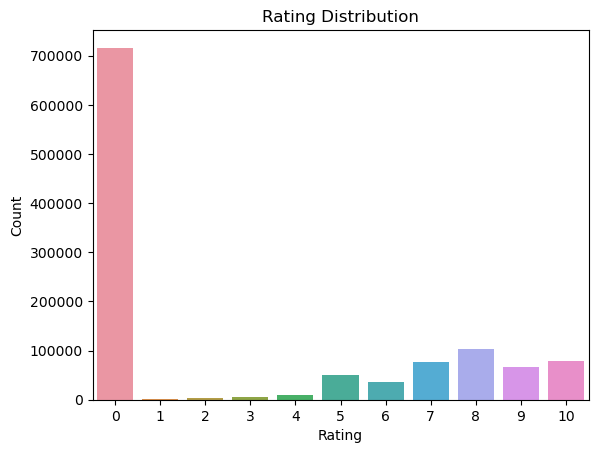

In [6]:
sns.countplot(x=df_ratings['bookRating'])
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('rating_distribution.png', bbox_inches='tight')
plt.show()

Most books have not been rated. We need to take this into consideration going forward. We will take data from:
- users who have rated atleast 20 books and
- book that have been rated atleast 50 times

In [7]:
#User rating counts
counting_u = df_ratings['userID'].value_counts()
user_rating = df_ratings[df_ratings['userID'].isin(counting_u[counting_u >= 20].index)]

#Book rating counts
counting_b = df_ratings['bookRating'].value_counts()
user_rating = df_ratings[df_ratings['bookRating'].isin(counting_b[counting_b >= 50].index)]

## Preprocessing

In [8]:
combined_rating = pd.merge(df_ratings, df_books, on='ISBN')

columns = ['yearOfPublication', 'publisher', 'bookAuthor', 'imageUrlS', 'imageUrlM', 'imageUrlL']
combined_rating = combined_rating.drop(columns, axis=1)

combined_rating.head()

,userID,ISBN,bookRating,bookTitle
0,276725,034545104X,0,Flesh Tones: A Novel
1,2313,034545104X,5,Flesh Tones: A Novel
2,6543,034545104X,0,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel


In [9]:
combine_book_rating = combined_rating.dropna(axis = 0, subset = ['bookTitle'])

book_rating_count = (combine_book_rating.
     groupby(by = ['bookTitle'])['bookRating'].
     count().
     reset_index().
     rename(columns = {'bookRating': 'total_rating_count'})
     [['bookTitle', 'total_rating_count']]
    )
book_rating_count.head()

,bookTitle,total_rating_count
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


Combine the rating data with the total rating count data. This gives exactly what is needed to find out which books are popular.

In [10]:
rating_with_totalRatingCount = combine_book_rating.merge(book_rating_count, left_on = 'bookTitle', right_on = 'bookTitle', how = 'left')
rating_with_totalRatingCount.head()

,userID,ISBN,bookRating,bookTitle,total_rating_count
0,276725,034545104X,0,Flesh Tones: A Novel,60
1,2313,034545104X,5,Flesh Tones: A Novel,60
2,6543,034545104X,0,Flesh Tones: A Novel,60
3,8680,034545104X,5,Flesh Tones: A Novel,60
4,10314,034545104X,9,Flesh Tones: A Novel,60


Let's set the threshold for filtering and returning popular books.

In [11]:
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query('total_rating_count >= @popularity_threshold')
rating_popular_book.head()

,userID,ISBN,bookRating,bookTitle,total_rating_count
0,276725,034545104X,0,Flesh Tones: A Novel,60
1,2313,034545104X,5,Flesh Tones: A Novel,60
2,6543,034545104X,0,Flesh Tones: A Novel,60
3,8680,034545104X,5,Flesh Tones: A Novel,60
4,10314,034545104X,9,Flesh Tones: A Novel,60


## Model

KNN would be helpful in finding clusters so that the users can be recommended books similar to the ones they are reading.

In [12]:
#Combine data into a final dataframe
df_final = rating_popular_book.merge(df_users, left_on = 'userID', right_on = 'userID', how = 'left')
df_final = df_final.drop_duplicates(['userID', 'bookTitle'])

#Make a pivot table and turn it into a sparse matrix
user_rating_pivot = df_final.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating').fillna(0)
user_rating_matrix = csr_matrix(user_rating_pivot.values)

#Fit KNN model
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [13]:
joblib.dump(model_knn, 'KNN_model.joblib')

['KNN_model.joblib']

In [14]:
# user_rating_pivot

In [15]:
query_index = np.random.choice(user_rating_pivot.shape[0])
distances, indices = model_knn.kneighbors(user_rating_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 11)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for The Echo:

1: The Dark Room, with distance of 0.869058977230975:
2: Birdman, with distance of 0.8784832400881151:
3: The Law of Love, with distance of 0.9099106016690466:
4: Dark Paradise, with distance of 0.9163647896558396:
5: Now and Forever, with distance of 0.9262780206756078:
6: The Red Room, with distance of 0.9269156161940985:
7: Weep No More, My Lady, with distance of 0.9282169259000226:
8: The Cabinet of Curiosities, with distance of 0.9287069817632757:
9: Archangel, with distance of 0.9290678325750317:
10: The Ice House, with distance of 0.9299554761111845:


In [16]:
save_df = df_final
save_pivot = user_rating_pivot
save_pivot.columns = save_pivot.columns.astype(str)

In [19]:
save_df[['ISBN', 'bookTitle']].reset_index().to_feather('final_df.feather')
save_pivot.reset_index().to_feather('user_rating_pivot.feather')

To use the recommendation model, run the code below. Enter the name of any book. Change <code>n_neighors</code> if you want to get more or less books. Eg; <code>n_neighbors = 11</code> will return 10 books.

In [20]:
book_name = 'Brazen Virtue'
a = user_rating_pivot.index.get_loc(book_name)

distances, indices = model_knn.kneighbors(user_rating_pivot.iloc[a,:].values.reshape(1, -1), n_neighbors = 11)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(user_rating_pivot.index[a]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Brazen Virtue:

1: Public Secrets, with distance of 0.7528580854980171:
2: Carnal Innocence, with distance of 0.7597677131383788:
3: Night Shield (Intimate Moments, 1027), with distance of 0.7690474461610141:
4: Sea Swept (Quinn Brothers (Paperback)), with distance of 0.7760366029412986:
5: Private Scandals, with distance of 0.7834822779136846:
6: Three Fates, with distance of 0.798658493512428:
7: Inner Harbor (Quinn Brothers (Paperback)), with distance of 0.8068623504191991:
8: Sacred Sins, with distance of 0.8075336926005272:
9: The Reef, with distance of 0.8128962609883355:
10: Storm Warning, with distance of 0.8141800978670536:
